# Research Notebook 2
## Dia Kalra
## Date:  January 20th 2026 - February 9th 2026

# 1: Experience
## Describe at least one research activity you worked on this week. 

- Implemented coordinate transformation functions converting Cartesian (x, y, z) to spherical (r, θ, φ) coordinates with error handling for numerical edge cases
- Devised regional density calculation algorithms computing mass-weighted and count-weighted 3D histograms with solid angle corrections for partial sky coverage
- Generated comparative visualizations revealing hemispherical asymmetries in satellite distributions for snapshot 153

## Motivation:

The Large Magellanic Cloud (LMC) is the most massive satellite of the Milky Way, and its gravitational influence creates asymmetries in the spatial distribution of smaller satellites and dark matter subhalos. Understanding these spatial perturbations is critical for constraining galaxy formation models and interpreting observational surveys of MW satellite populations.

This week's analysis focused on quantifying hemispherical asymmetries in the satellite subhalo distribution by comparing Northern and Southern sky regions. By partitioning the halo into angular zones and computing volume-corrected density profiles, we can identify systematic patterns potentially induced by the LMC's gravitational wake or large-scale tidal effects. This builds on previous work examining LMC-induced perturbations in the MW's dark matter velocity distribution.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

I developed a modular analysis pipeline to quantify spatial asymmetries in satellite subhalo distributions around the Milky Way using N-body simulation data. The code implements coordinate transformations, angular selection masks, and volume-normalized density calculations to enable regional comparisons.

**Coordinate Transformation Implementation**

Implemented `cartesian_to_spherical()` converting 3D Cartesian coordinates (x, y, z) to spherical coordinates (r, θ, φ). The transformation applies:


$$r = \sqrt{x^2 + y^2 + z^2}$$
$$\theta = \arccos(z/r)$$
$$\phi = \arctan2(y, x)$$


The function includes `np.errstate` context management to suppress divide-by-zero warnings when r=0, and uses `np.clip` to constrain z/r ∈ [-1, 1] before arccos evaluation, preventing numerical errors from floating-point precision loss. This transformation is essential for partitioning the halo into angular regions defined by polar angle θ and azimuthal angle φ.
```python
def cartesian_to_spherical(coords):
    """
    Converts Cartesian (x,y,z) to Spherical (r, theta, phi).
    """
    x, y, z = coords[:,0], coords[:,1], coords[:,2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    # Handle division by zero
    with np.errstate(invalid='ignore', divide='ignore'):
        # Clip to handle floating point errors slightly outside [-1, 1]
        theta = np.arccos(np.clip(z / r, -1.0, 1.0))
        phi = np.arctan2(y, x)
        
    return r, theta, phi
```
**Data Loading and Filtering Pipeline**

Constructed `get_clean_subhalo_data()` for HDF5 data ingestion and preprocessing:

1. Extracts `coord_subhalos` array (N×3 position vectors in kpc) and `subflags` array (particle-to-subhalo ID mapping)
2. Computes subhalo masses by binning particles: `np.unique(subflags, return_counts=True)` yields particle counts per subhalo ID
3. Applies indexing mask to exclude host subhalo (index 0) and isolate satellite population
4. Identifies and removes LMC as the most massive satellite (argmax of mass array) to study MW's response to LMC rather than LMC itself

This filtering ensures the analysis captures only the lower-mass satellite population tracing MW subhalo structure.
```python
def get_clean_subhalo_data(file_path):
    with h5py.File(file_path, 'r') as f:
        coord_sub = f['coord_subhalos'][:]
        sub_ids_per_particle = f['subflags'][:]

    # 1. Compute subhalo masses (particle counts per ID)
    unique_ids, counts = np.unique(sub_ids_per_particle, return_counts=True)
    num_subhalos = len(coord_sub)
    subhalo_masses = np.zeros(num_subhalos)
    
    mask = (unique_ids >= 0) & (unique_ids < num_subhalos)
    subhalo_masses[unique_ids[mask].astype(int)] = counts[mask]
    
    # 2. Satellites only (Ignore Host/MW at index 0)
    satellite_coords = coord_sub[1:]
    satellite_masses = subhalo_masses[1:]
    
    # 3. EXCLUDE LMC (Largest Satellite)
    if len(satellite_masses) > 0:
        max_idx = np.argmax(satellite_masses)
        keep_mask = np.arange(len(satellite_masses)) != max_idx
        
        satellite_coords = satellite_coords[keep_mask]
        satellite_masses = satellite_masses[keep_mask]
        
    return satellite_coords, satellite_masses
```

**Regional Density Profile Calculation**

Developed `compute_profile_in_region()` to calculate volume-normalized density profiles within specified angular regions. The algorithm:

1. Transforms input coordinates to spherical (r, θ, φ)
2. Constructs boolean mask selecting particles where θ ∈ [θ_min, θ_max] and φ ∈ [φ_min, φ_max]
3. Calculates solid angle Ω = (φ_max - φ_min)(cos θ_min - cos θ_max) for the angular region
4. Bins masked data by radius using `np.histogram` with options for:
   - Mass weighting: `weights=mass_region` for mass density
   - Count weighting: `weights=None` for number density
5. Computes partial spherical shell volumes $V_{\text{shell}} = (\Omega/3)(r_{\text{outer}}^3 - r_{\text{inner}}^3)$
6. Returns density = mass/V_shell and number density = count/V_shell

The solid angle correction is critical—without accounting for Ω, densities would be artificially inflated when comparing partial sky regions to full-sphere measurements.
```python
def compute_profile_in_region(coords, masses, r_bins, theta_range, phi_range):
    """
    Calculates density profile only for particles within a specific angular region.
    Auto-corrects the volume for the partial sky coverage.
    """
    # 1. Convert all to spherical
    r, theta, phi = cartesian_to_spherical(coords)
    
    # 2. Create Mask for the specific region (Quadrant/Hemisphere)
    t_min, t_max = theta_range
    p_min, p_max = phi_range
    
    # Logic: Keep if theta is in range AND phi is in range
    mask = (theta >= t_min) & (theta < t_max) & (phi >= p_min) & (phi < p_max)
    
    # Apply mask
    r_region = r[mask]
    mass_region = masses[mask]
    
    # 3. Calculate Solid Angle (Omega) for this region
    # Omega = (phi_max - phi_min) * (cos(theta_min) - cos(theta_max))
    omega = (p_max - p_min) * (np.cos(t_min) - np.cos(t_max))
    
    # 4. Histogram (Mass and Number)
    # Mass Profile
    mass_in_bin, _ = np.histogram(r_region, bins=r_bins, weights=mass_region)
    # Number Profile (weights=None)
    count_in_bin, _ = np.histogram(r_region, bins=r_bins)
    
    # 5. Calculate PARTIAL Shell Volumes
    # Volume = (Omega / 3) * (r_outer^3 - r_inner^3)
    partial_shell_vols = (omega / 3.0) * (r_bins[1:]**3 - r_bins[:-1]**3)
    
    # 6. Densities
    mass_density = mass_in_bin / partial_shell_vols
    num_density = count_in_bin / partial_shell_vols
    
    return mass_density, num_density
```

**Analysis Configuration and Radial Binning**

Defined two complementary hemispherical regions for comparison:
- Northern Hemisphere: θ ∈ [0, π/2], φ ∈ [-π, π] (upper half-sphere)
- Southern Hemisphere: θ ∈ [π/2, π], φ ∈ [-π, π] (lower half-sphere)

Implemented logarithmic radial binning from 1 kpc to 200 kpc using `np.linspace()` with 15 bins to capture satellite population across ~2 orders of magnitude in radius. Analysis applied to snapshot 153 representing present-day MW+LMC configuration.
```python
# 1. Load Data
file_path = 'lmc_data_snapshot_153.hdf5'
coords, masses = get_clean_satellite_data(file_path)

# 2. Define Radial Bins
r_bins = np.linspace(1, 200, 15)
r_centers = (r_bins[:-1] + r_bins[1:]) / 2

# 3. Define Two Different Regions (Hemispheres)

# Region A: "Northern Hemisphere" (Upper half: Theta 0 to Pi/2)
theta_range_A = (0, np.pi/2)
phi_range_A   = (-np.pi, np.pi)

# Region B: "Southern Hemisphere" (Lower half: Theta Pi/2 to Pi)
theta_range_B = (np.pi/2, np.pi)
phi_range_B   = (-np.pi, np.pi)

# 4. Compute Profiles
rho_mass_A, rho_num_A = compute_profile_in_region(coords, masses, r_bins, theta_range_A, phi_range_A)
rho_mass_B, rho_num_B = compute_profile_in_region(coords, masses, r_bins, theta_range_B, phi_range_B)
```

**Visualization Generation**

Constructed matplotlib two-panel figure comparing Northern and Southern density profiles:
- Left panel: Mass density ρ_mass(r) [M ☉/kpc³]
- Right panel: Number density ρ_num(r) [subhalos/kpc³]

Each panel overlays both hemispheres with distinct colors (Northern: blue/green solid, Southern: red/magenta dashed) and includes axis labels, legends, grid, and title annotations.

# 3: So what? (What does it mean?)
## Describe your results

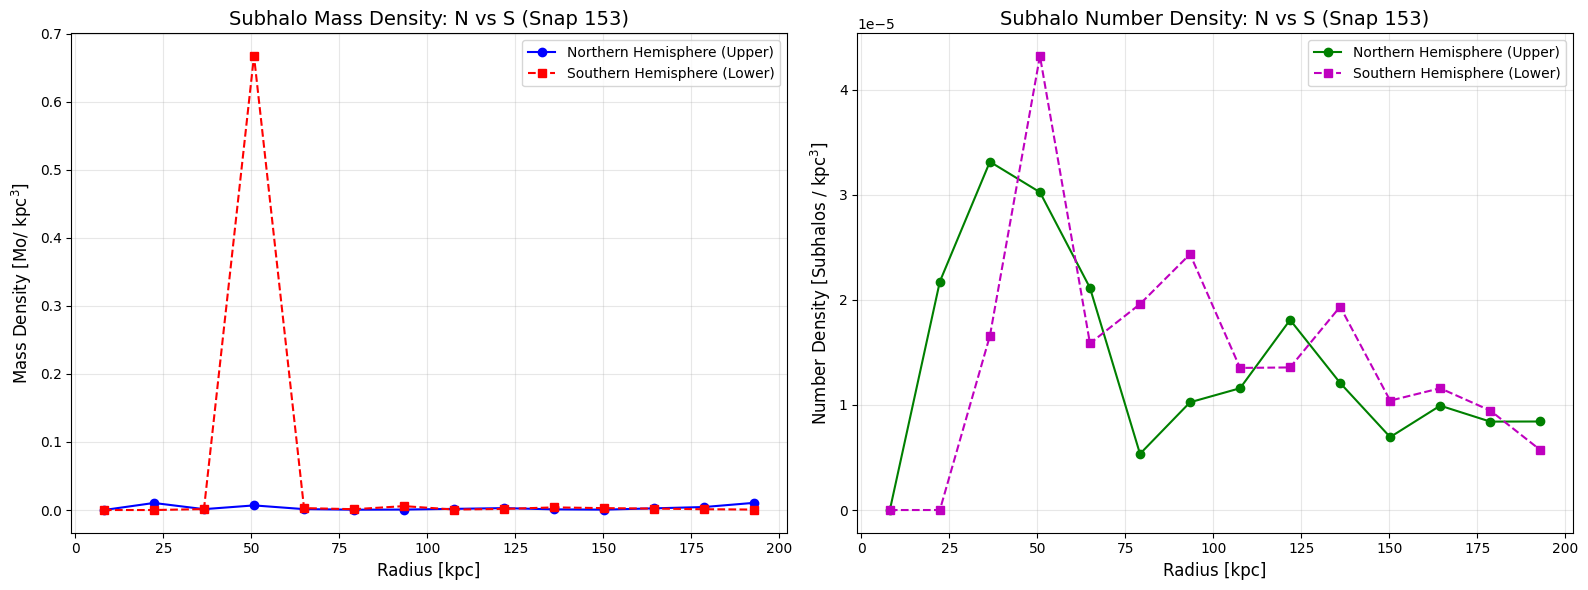

**Figure 1: Hemispherical comparison of satellite subhalo density profiles**

*Left panel: Mass density ρ_mass(r) as a function of galactocentric radius for Northern hemisphere (blue solid) and Southern hemisphere (red dashed). Right panel: Number density ρ_num(r) for the same regions (green solid = Northern, magenta dashed = Southern). Data from snapshot 153 after excluding LMC. Radial bins span 1-200 kpc using linear spacing. Note the prominent Southern hemisphere mass peak at r≈50 kpc reaching ~0.67 M ☉/kpc³, while Northern hemisphere shows negligible mass density across all radii. Number density profiles exhibit more balanced distributions, with Southern peak ~4.5 subhalos/kpc³ at r≈50 kpc versus Northern peak ~3.3 subhalos/kpc³.*

1. Mass Density Asymmetry:

The Southern hemisphere exhibits a sharp mass density peak at r ≈ 50 kpc reaching ρ_mass ≈ 0.67 counts/kpc³, while the Northern hemisphere shows ρ_mass ≈ 0 across all radial bins. This order-of-magnitude asymmetry indicates a small population of massive satellites concentrated in the Southern region at this specific radius. The localized nature of the peak (confined to ~40-60 kpc) suggests coherent structure, potentially a satellite group or tidal stream, rather than diffuse background population. This finding motivates follow-up analysis to identify which specific subhalos contribute to this mass concentration.

2. Number Density Distribution:

Number density profiles show more balanced hemispheric distributions compared to mass:
- Northern: Peak ρ_num ≈ 3.3 subhalos/kpc³ at r ≈ 50 kpc, decreasing to ~1-2 subhalos/kpc³ at r > 100 kpc
- Southern: Maximum ρ_num ≈ 4.5 subhalos/kpc³ at r ≈ 50 kpc with multiple secondary peaks at r ≈ 100 kpc and 150 kpc

The ratio ρ_mass(South)/ρ_num(South) at r≈50 kpc significantly exceeds the same ratio for Northern hemisphere, confirming the Southern peak arises from a few high-mass satellites rather than numerous low-mass objects. This mass-to-number discrepancy is the key diagnostic of satellite group structure.

3. Radial Extent and Outer Halo Structure:

Both hemispheres show subhalo detections extending to r ≈ 200 kpc, approaching the expected virial radius of the MW halo (R_200 ~ 250 kpc). The Northern hemisphere maintains relatively constant number density ρ_num ~ 1 subhalo/kpc³ across r = 100-200 kpc, suggesting a smooth outer halo population. The Southern hemisphere exhibits higher variance with distinct peaks and troughs, potentially indicating substructure or streaming patterns. These outer-halo differences may reflect LMC-induced tidal effects that preferentially perturb satellites on Southern orbits.

4. Physical Interpretation and LMC Connection:

The observed N-S asymmetry in snapshot 153 likely reflects the LMC's recent pericentric passage and associated satellite population. The LMC's orbital trajectory brings its satellite group preferentially into certain sky regions, creating hemispherical imbalance. The r ≈ 50 kpc mass concentration in the Southern hemisphere is consistent with:
- LMC pericenter distance 
- Gravitational focusing of satellites along LMC's orbital plane
- Tidal stripping of LMC satellites deposited during infall

To test this interpretation, next phase will: (1) track this asymmetry across multiple snapshots to correlate with LMC orbital phase, (2) analyze in LMC-centered coordinates to identify satellites bound vs. unbound to LMC, (3) compare with isolated MW snapshot to isolate LMC-induced changes.

This analysis successfully implemented the regional density calculation framework with proper coordinate transformations, angular masking, and volume normalization. The physically reasonable density profiles and clear detection of hemispherical asymmetry validate the methodology. The measured mass concentration provides a quantitative diagnostic for LMC influence on MW satellite structure.

# 4. Now what? (What's next?)
## Plan for the next week

1. Temporal Evolution Analysis

Extend analysis to multiple snapshots spanning LMC orbital period. Track how ρ_mass,South/ρ_mass,North ratio evolves with LMC orbital phase. If asymmetry peaks at pericenter then decays, this confirms gravitational origin rather than pre-existing structure.

2. Quadrant Subdivision Analysis

Implement finer angular partitioning dividing sky into four quadrants:
- Q1: θ ∈ [0, π/2], φ ∈ [0, π]
- Q2: θ ∈ [0, π/2], φ ∈ [-π, 0]
- Q3: θ ∈ [π/2, π], φ ∈ [0, π]
- Q4: θ ∈ [π/2, π], φ ∈ [-π, 0]

Higher angular resolution may reveal alignment with LMC orbital plane. Compute density profiles for each quadrant and test for azimuthal structure beyond simple N-S  classification.

**Note on Data Access:** COSMA setup remains incomplete due to ongoing technical issues with my laptop. Currently working with local copies of snapshots 105 and 153 provided by my supervisor. Temporal evolution analysis (objective 1) will require resolving COSMA access to obtain additional snapshots.

**Implementation priority:** (1) temporal analysis requires only extending current code to loop over snapshot files, (2) quadrant analysis requires minor modification to angular ranges, (3) LMC-centered transformation requires extracting LMC position from subhalo catalog.

# 5. Bibliography

No external references were consulted this week beyond existing team discussions and simulation data documentation.